# 06. PyTorch Transfer Learning Exercises

List of things to do in this exercise
- Use 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip' as data for training and testing
- Create train and test dataloader, same as efficientnet_b0
- Use transfer learning on efficientnet_b0 and adjust it for three classes
- Train the model, and test it
- Develop a function to test on custom images "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg"  

## 1. Imports and Device Agnostic Code

In [ ]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [ ]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2. Data Download and Organization

In [ ]:
### Data Download and Organization ###
from pathlib import Path
import requests
import zipfile
import os

# Setup data and image path
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# Create image directory
if image_path.is_dir():
  print(f'Image path already exists, skipping creation')
else:
  print(f'Creating image path')
  image_path.mkdir(parents=True, exist_ok=True)

# Download 20% pizza, steak, sushi dataset from GitHub
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  print(f'Downloading 20% data')
  requests = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip')
  f.write(requests.content)

# Open zipfile of 20% pizza, steak, sushi dataset
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zipfile:
  print(f'Unzipping 20% data')
  zipfile.extractall(image_path)

# Delete zipfile
os.remove(data_path / 'pizza_steak_sushi.zip')

Image path already exists, skipping creation
Unzipping 20% data


In [ ]:
# Create test and training paths
train_path = image_path / 'train'
test_path = image_path / 'test'

In [ ]:
### Auto-Creation of Transform ###
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
transform = weights.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create a training dataset and testing dataset
training_dataset = datasets.ImageFolder(
    root=train_path,
    transform=transform
)
testing_dataset = datasets.ImageFolder(
    root=test_path,
    transform=transform
)
training_dataset, testing_dataset

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ))

In [ ]:
from torch.utils.data import DataLoader
import os

# Create hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create a training dataloader and a testing dataloader
training_dataloader = DataLoader(
    dataset=training_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

testing_dataloader = DataLoader(
    dataset=testing_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)
training_dataloader, testing_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78b1fc5bd100>,
 <torch.utils.data.dataloader.DataLoader at 0x78b1fc5bcbc0>)

## 3. Adjust EfficientNet_B0 for Food Classification on 3 Classes

In [ ]:
# Use transfer learning to create a model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [ ]:
# Create a model summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names']
        )

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                

In [ ]:
### Update transferred model to predict on 3 image classes ###
# Freeze the feature layers in the model
for params in model.features.parameters():
  params.requires_grad = False

# Update the classifier layer to predict on 3 image classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=3,
              bias=True)
)

In [ ]:
# Generate a summary of the updated transferred model
summary(model=model,
        input_size = (32, 3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

## 4. Training and Testing Model

In [ ]:
# Setup the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
from tqdm.auto import tqdm

# Initialize the number of epochs
epochs = 10

for epoch in tqdm(range(epochs)):
  ### Training Step ###
  # Put the model in training mode
  model.train()

  # Initialize final train loss and accuracy
  train_loss = 0
  train_accuracy = 0

  # Loop through each batch in training dataloader
  for batch, (X, y) in enumerate(training_dataloader):
    # Put the data on the target device
    X, y = X.to(device), y.to(device)

    # Do the forward pass
    train_logits = model(X)

    # Calculate the loss
    loss = loss_fn(train_logits, y)
    train_loss += loss

    # Convert train logits to train labels
    train_labels = torch.softmax(train_logits, dim=1).argmax(dim=1)
    train_accuracy += (train_labels == y).sum().item()/len(y)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

  # Calculate final loss and accuracy
  train_loss = train_loss / len(training_dataloader)
  train_accuracy = train_accuracy / len(training_dataloader)

  ### Testing Step ###
  # Put model in eval mode
  model.eval()

  # Initialize final test loss and accuracy
  test_loss = 0
  test_accuracy = 0

  with torch.inference_mode():
    # Loop through each batch in testing dataloader
    for batch, (X, y) in enumerate(testing_dataloader):
      # Put data on target device
      X, y = X.to(device), y.to(device)

      # Do the forward pass
      test_logits = model(X)

      # Calculate the loss
      loss = loss_fn(test_logits, y)
      test_loss += loss

      # Convert test logits to test labels
      test_labels = torch.softmax(test_logits, dim=1).argmax(dim=1)
      test_accuracy += (test_labels == y).sum().item()/len(y)

  # Calculate final loss and accuracy
  test_loss = test_loss / len(testing_dataloader)
  test_accuracy = test_accuracy / len(testing_dataloader)

  # Print out what's happening
  print(f'Epoch: {epoch} | Training Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Training Loss: 0.9520 | Training Accuracy: 0.5917 | Test Loss: 0.6752 | Test Accuracy: 0.9034
Epoch: 1 | Training Loss: 0.7096 | Training Accuracy: 0.8000 | Test Loss: 0.5469 | Test Accuracy: 0.8943
Epoch: 2 | Training Loss: 0.5578 | Training Accuracy: 0.8708 | Test Loss: 0.4688 | Test Accuracy: 0.9097
Epoch: 3 | Training Loss: 0.5113 | Training Accuracy: 0.8812 | Test Loss: 0.4355 | Test Accuracy: 0.8886
Epoch: 4 | Training Loss: 0.4435 | Training Accuracy: 0.8646 | Test Loss: 0.3902 | Test Accuracy: 0.8943
Epoch: 5 | Training Loss: 0.3743 | Training Accuracy: 0.9021 | Test Loss: 0.3622 | Test Accuracy: 0.8972
Epoch: 6 | Training Loss: 0.3689 | Training Accuracy: 0.9187 | Test Loss: 0.3483 | Test Accuracy: 0.9040
Epoch: 7 | Training Loss: 0.3174 | Training Accuracy: 0.9313 | Test Loss: 0.3207 | Test Accuracy: 0.9034
Epoch: 8 | Training Loss: 0.3717 | Training Accuracy: 0.9167 | Test Loss: 0.3193 | Test Accuracy: 0.9284
Epoch: 9 | Training Loss: 0.3333 | Training Accuracy: 0

## 5. Prediction on Custom Image

data/custom_image already exists


(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

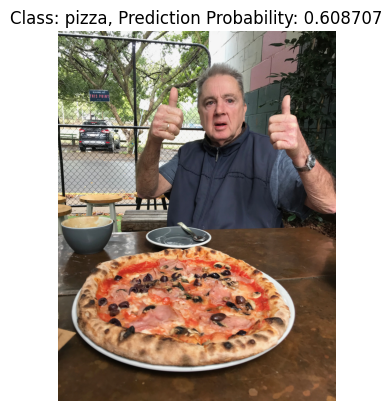

In [ ]:
from PIL import Image
from pathlib import Path
import requests

# Define a custom image path
custom_image_path = data_path / 'custom_image'

# Create a custom image path
if custom_image_path.is_dir():
  print(f'{custom_image_path} already exists')
else:
  print(f'Creating {custom_image_path}')
  custom_image_path.mkdir(parents=True, exist_ok=True)

with open(custom_image_path / 'custom_image_file', 'wb') as f:
  # Download custom image from GitHub
  requests = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
  f.write(requests.content)

# Get cdustom image and custom image dimensions
original_custom_image = Image.open(custom_image_path / 'custom_image_file')

# Transform the custom image
custom_image = transform(original_custom_image).unsqueeze(dim=0)

# Run the transformed image through the model
model.eval()
with torch.inference_mode():
  # Do the foward pass
  custom_logits = model(custom_image.to(device))

  # Convert to custom prediction labels
  custom_labels = torch.softmax(custom_logits, dim=1).argmax(dim=1)
  custom_preds = torch.softmax(custom_logits, dim=1)

# Convert custom label to class name
classes = ['pizza', 'steak', 'sushi']
custom_class = classes[custom_labels]

# Plot the image
plt.imshow(original_custom_image)
plt.title(f'Class: {custom_class}, Prediction Probability: {custom_preds.max():1f}')
plt.axis(False)